In [101]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numba
import pandas as pd
from matplotlib.pyplot import cm
from numba import float64

In [102]:
###define cutoff radius!!! 
'''
def cutoffinteraction(rij: float64, rcut: float64) -> float64: ###not too small so that we have pair-wise interactions!!! Slightly smaller than the box size(simbox)
    if rij> rcut:
        rij=0
    return rij

@numba.njit
def cutoffinteraction(rij, rcut): 
    if np.linalg.norm(rij) > rcut:
        return np.zeros_like(rij)
    return rij'''
@numba.njit
def cutoffimage(forces ,rij ,rcut):
    up, down= np.where(rij > rcut), np.where(-1*rij > rcut)
    forces[up] = 0
    forces[down] = 0
    return forces 

##make on for energies?

In [103]:
@numba.njit
def generate_fcc_positions(nx, ny, nz, rho, dtype=np.float32): ##put fcc lattices according to the density
    D=3  #D is set to 3, representing a three-dimensional space. 
    conf = np.zeros((nx*ny*nz*4, D), dtype=dtype) 
    count = 0 
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                conf[count+0,:] = [ix+0.25, iy+0.25, iz+0.25]
                conf[count+1,:] = [ix+0.75, iy+0.75, iz+0.25]
                conf[count+2,:] = [ix+0.75, iy+0.25, iz+0.75]
                conf[count+3,:] = [ix+0.25, iy+0.75, iz+0.75]
                count += 4
    for k in range(D):
        conf[:,k] -= np.mean(conf[:,k]) # put sample in the middle of the box
        
    sim_box = np.array((nx, ny, nz), dtype=dtype) #simulation box
    rho_initial = 4.0
    scale_factor = dtype((rho_initial/rho)**(1/D)) # scale both the positions (conf) and the simulation box (sim_box). 
    #This scaling ensures that the final density of the generated configuration matches the desired rho.
    
    return conf*scale_factor, sim_box*scale_factor

def generate_random_velocities(N, D, T, dtype=np.float32):
    v = dtype(np.random.normal(0.0, T**0.5, (N,D)))    ###### Assuming m=1, ######
    for k in range(D):
        v[:,k] -= np.mean(v[:,k]) # remove drift
        #So the mean of every element subtracted by the mean is zero
    return v
###CHANGE THIS TO NUMBA ACCORDING TO THE LINK ON MOODLE(NUMBASCALER ETC..)
####(have a graph with them and check variance)
@numba.njit
def lj_potential(r, epsilon=1.0, sigma=1.0):
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

###change this to numba-> slow part
#@numba.njit
def calculate_potential_energy(R, L):
    ###change the way I calculate it with image convenction(the same function!!!!)
    N, D = R.shape
    distances = np.zeros(len(R)) 
    energy = 0.0
    for i in range(N):
        ##should I do it with nearest neighbours?
        for j in range(i + 1, N):
            distance = np.linalg.norm(R[i] - R[j])  # Euclidean distance between particles i and j
            #cutoffinteraction(distance,L/2)
            print(type(distance <L/2)) ##float 64 vs float 32
            ###change this!!!
            #if (distance < L/2): ###minimum image convention.Maybe with any?
            energy += lj_potential(distance)
            #d_i += distance
            #distances[i] += distance
    return energy #, distances
@numba.njit
def VerletNextR(r_t, v_t, a_t, h, L):
    r_t_plus_h = r_t + v_t*h + 0.5*a_t*h*h
    return r_t_plus_h
@numba.njit
def VerletNextV(v_t,a_t,a_t_plus_h,h):
    v_t_plus_h = v_t + 0.5*(a_t + a_t_plus_h)*h
    return v_t_plus_h
@numba.njit
def kinetic_energy(V, M):
    return np.sum(V**2)*M*0.5
@numba.njit
def calculate_forces(R, L):
    # N,D = R.shape 
    N = len(R)
    ####epsilon = 1e-9
    forces = np.zeros_like(R)
    for i in range(N):
        for j in range(i + 1, N):
            ###make a function: if statement boundary conditions with image boundary condition!!!!
            ###I could define a cutoff radius
            rij = R[j] - R[i]    ###D dimentional. vector point from i to j
            #rij =cutoffinteraction(rij,L/2)
            #if np.round(rij / L) * L != rij:
            #rij = r % L
            r = np.linalg.norm(rij)
            ''' 
            if r % L != 0:
                r = r % L ####ERROR!!!!!
            if np.round(r / L) * L != r:
                r -= np.round(r / L) * L ###subtract the displacement'''
            ### np.round(r / L): how many times the particle has crossed the simulation box boundary
            # L: the displacement needed to wrap the particle back into the simulation box
            ###r += epsilon ## ensure it does not go to 0
            ###change forces
            f = -48 * (1 / (r ** 14) - 0.5 / (r ** 8)) * rij 
            ##newton's 3rd law reaction-pair: conservation of energy
            f =cutoffimage(f ,rij ,L/2)
            forces[i] += f
            forces[j] -= f
    return forces

In [104]:
##implement boundary conditions
''' # apply periodic boundary conditions
    pos_f = pos_f % box_side
    
    # periodic boundary
    dist_vecs_pbc = (dist_vecs + box_side / 2) % box_side - box_side / 2
    
    '''
    
    ##tau =0.2 test periodic first and then paper, also test periodic with looping T!!!(do it in small steps so it doesnt explode)

' # apply periodic boundary conditions\n    pos_f = pos_f % box_side\n    \n    # periodic boundary\n    dist_vecs_pbc = (dist_vecs + box_side / 2) % box_side - box_side / 2\n    \n    '

In [105]:
conf, simbox = generate_fcc_positions(3, 3, 3, 1.0, dtype=np.float32)
vel = generate_random_velocities(conf.shape[0], conf.shape[1], T=1) ##if T= 0 they should be 0
conf2 = conf+ np.random.uniform(-1,+1, conf.shape)*0.1
#forces = calculate_forces(conf2, 3)  
nrg = calculate_potential_energy(conf2, simbox)
#print(vel)
print(conf[:5,:])
print(simbox)
#print(forces[0,:])
print(nrg)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

In [106]:
###MAKE FUNCTIONS TO CHECK BOUNDARIES!
def check_boundaries(positions, L):
    up, down= np.where(positions > L/2), np.where(-1*positions > L/2)
    positions[up] -= L
    positions[down] += L
    return positions 

In [107]:
#calculate_forces(conf+ np.random.uniform(-1,+1, conf.shape)*0.1)  
###"mostly should kinda be 0 but some particles are missing neighbours and we do not have an infinite sample"
##"the nearest neighbours should be 0 but then you have neighbours further away and in an infinite sample they should cancel out"

In [108]:
#@numba.njit
#@numba.njit(nopython=True)
###Thomas usas a similar for the lj for the spring: TRY IT AT HOME!
def simulate(Ncube, T0, L, M, steps, h):
    #N = Ncube**3
    R = generate_fcc_positions(Ncube, Ncube, Ncube, 1.0, dtype=np.float32)[0]
    V = generate_random_velocities(len(R), 3, T0, dtype=np.float32)
    A = np.zeros((len(R),3))
    
    K = np.zeros(steps)
    E = np.zeros(steps)
    Pos_history = np.zeros((steps, len(R), 3), dtype=np.float32)  ###make this a numpy array of numpy arrays 3d
    distance = np.zeros(steps)
    
    #print("R is:",R)
    #print("V is:",V)
    #print(len(R), len(V), len(A))

    for t in range(0, steps): ###try to change the time
        #t = t+dt
        newEt  = calculate_potential_energy(R, L)
        E[t] = newEt
        F = calculate_forces(R, L)
        A = F/M
        ###force wall?
        newR = VerletNextR(R, V, A, h, L)
        Pos_history[t] = newR.reshape(3,-1).T
        check_boundaries(newR[0], L) 
        newF = calculate_forces(newR, L)## calculate forces with new positions newR
        newA = newF/M
        newV = VerletNextV(V, A, newA, h)
        
        # update positions:
        R, V = newR, newV
        K[t] = kinetic_energy(V, M) ###this returns a float!!!HELP!
    return E, distance, V, Pos_history, K

In [109]:
M = 1.0

Ncube = 3
N = Ncube**3

###change it to != cube (we assume that Lx =Ly= Lz, so change so that they can be different)
L = simbox[0] 

T0 = 0.01 ##this should start with 0
### try to change the temperature to see how it varies!!
###time it!
steps = 1000
#steps = 20
h= 0.01
Es, distances, V, Pos_history, K = simulate(Ncube, T0, L, M, steps, h)

<class 'numpy.bool_'>


<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'nu

1000 1000


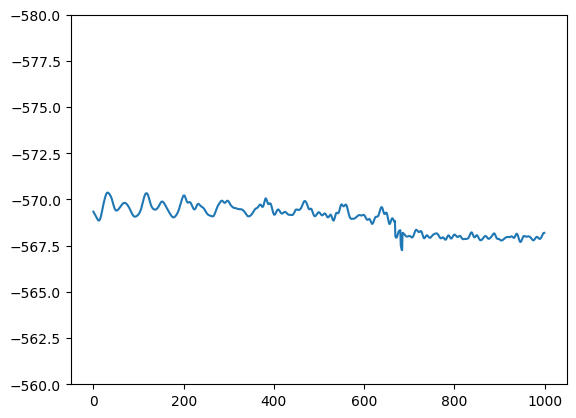

In [ ]:
TotalE = K + Es
print(len(K), len(Es))
plt.plot(np.arange(0, steps, 1, dtype=int),TotalE)
plt.ylim(-560, -580)
VarE = np.var(TotalE) ###get the variance in a numpy array (maybe in relation to the average!!!)

1000 108


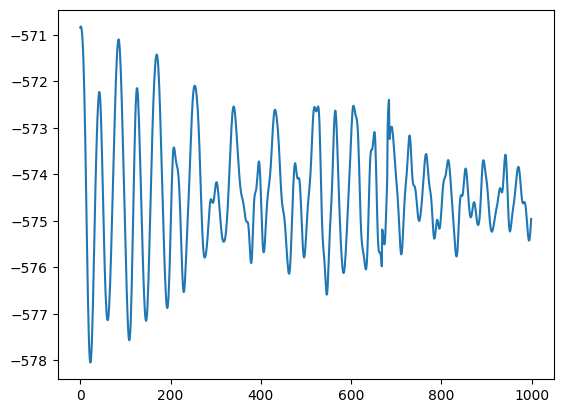

In [ ]:
plt.plot(Es)
#plt.ylim(0,1000)
#plt.xlim(1,1.19)
print(len(distances), len(V))

###Try to plot the particles
#####calculate kineticb energy and see if total is contant

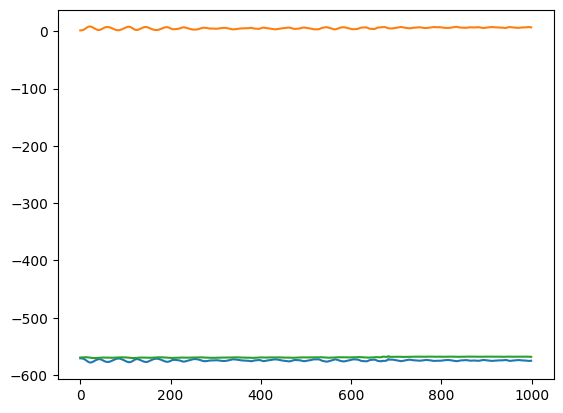

In [ ]:

###plot of energies
plt.plot(Es)
plt.plot(K)
plt.plot(K+Es)
#print(type(K))
#print(K+Es)

In [ ]:
Es

array([-570.84100228, -570.81696214, -570.82750143, -570.87589587,
       -570.96687943, -571.10614711, -571.29977212, -571.55338794,
       -571.87119135, -572.25505036, -572.70354789, -573.2110428 ,
       -573.76752115, -574.35847695, -574.96546753, -575.5673713 ,
       -576.14187184, -576.66735241, -577.1247144 , -577.49891227,
       -577.78007431, -577.963676  , -578.0500312 , -578.04302977,
       -577.9486196 , -577.77350546, -577.52453937, -577.20899356,
       -576.83550256, -576.41510735, -575.96172054, -575.49154401,
       -575.02143563, -574.56673098, -574.1393283 , -573.74678525,
       -573.39277668, -573.0787183 , -572.8059182 , -572.57745432,
       -572.3991245 , -572.2791784 , -572.22694665, -572.25078723,
       -572.35591538, -572.54268844, -572.80579799, -573.1345744 ,
       -573.51427346, -573.92791999, -574.3581802 , -574.78886066,
       -575.20587538, -575.59771694, -575.95553173, -576.27287531,
       -576.54523215, -576.76939906, -576.94291299, -577.06364

C:\Users\35196\AppData\Local\Temp\ipykernel_36904\3742093442.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=100, c=c) #, alpha = t/steps


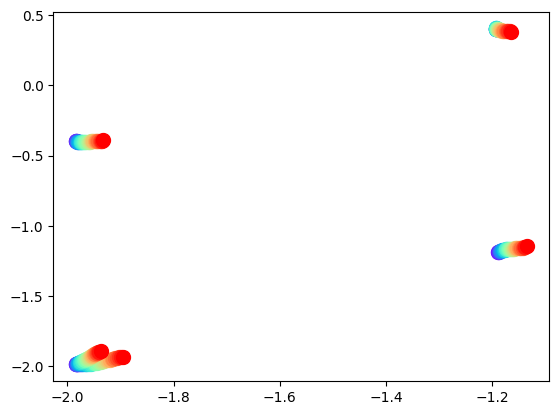

1000

In [ ]:
###see particles
n_colours = 30
colour = iter(cm.rainbow(np.linspace(0, 1, n_colours)))
for t in range(0,n_colours): ##number of steps
    c = next(colour)
    for i in range(5): ###number of particles
        x = Pos_history[t][i][0]  # x-coordinate
        y = Pos_history[t][i][1]  # y-coordinate   
        #plt.scatter(x, y, s=100,c ='green', alpha = t/steps)  # Plot point with specified size and color
        plt.scatter(x, y, s=100, c=c) #, alpha = t/steps
plt.show()
len(Pos_history)